# Application: Galaxy Classification with Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

We'll need the `Galaxy` class we defined earlier.

In [4]:
galaxy_types = {0: "disturbed galaxies",
                1: "merging galaxies",
                2: "round smooth galaxies",
                3: "in-between round smooth galaxies",
                4: "cigar shaped smooth galaxies",
                5: "barred spiral galaxies",
                6: "unbarred tight spiral galaxies",
                7: "unbarred loose spiral galaxies",
                8: "edge-on galaxies without bulge",
                9: "edge-on galaxies with bulge"}

In [5]:
class Galaxy:
    def __init__(self, data, answer, *, index=-1):
        self.data = np.array(data, dtype=np.float32) / 255.0
        self.answer = answer

        self.index = index

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.imshow(self.data, interpolation="nearest")
        ax.text(0.025, 0.95, f"answer: {self.answer}",
                color="white", transform=ax.transAxes)

    def validate(self, prediction):
        """check if a categorical prediction matches the answer"""
        return np.argmax(prediction) == self.answer

## A data manager class

We'll create a class to manage access to the data.  This is similar to the version in our "from scratch" implementation,
except we provide a generator to Keras.  

This will do the following:

* open the file and store the handles to access the data
* partition the data into test and training sets
* provide a means to shuffle the data
* provide a [generator](https://wiki.python.org/moin/Generators) to get the next *batch* of training data
* allow us to coarsen the images to a reduced resolution to make the training easier.

```{tip}
We will read all of the data once, which will take about 3.5 GB of memory.  It is kept
as a `uint8` until needed.
```

In [8]:
from keras.utils import to_categorical

In [9]:
class DataManager:
    def __init__(self, partition=0.8,
                 batch_size=32,
                 datafile="Galaxy10_DECals.h5",
                 coarsen=1):
        """manage access to the data

        partition: fraction that should be training
        datafile: name of the hdf5 file with the data
        coarsen: reduce the number of pixels by this factor
        """

        self.ds = h5py.File(datafile)
        self.ans = np.array(self.ds["ans"])
        self.images = np.array(self.ds["images"])

        self.coarsen = coarsen

        self.batch_size = batch_size
        
        N = len(self.ans)

        # create a set of indices for the galaxies and randomize
        self.indices = np.arange(N, dtype=np.uint32)
        self.rng = np.random.default_rng()
        self.rng.shuffle(self.indices)

        # partition into training and test sets
        # these indices will always refer to the index in the original
        # unsplit dataset
        n_cut = int(partition * N)

        # we want this to be a multiple of the batch size
        n_cut -= n_cut % self.batch_size

        self.training_indices = self.indices[0:n_cut]
        self.test_indices = self.indices[n_cut:N]

        self.n_training = len(self.training_indices)
        self.n_test = len(self.test_indices)

        # shape information
        self.input_shape = len(self._get_galaxy(0).reshape(-1))

        # number of batches for the training
        self.n_batches = n_cut // self.batch_size
    
    def _get_galaxy(self, index):
        """return a numpy array containing a single galaxy image, coarsened
        if necessary by averaging"""
        _tmp = self.images[index, :, :, :]
        if self.coarsen > 1:
            _tmp = np.mean(_tmp.reshape(_tmp.shape[0]//self.coarsen, self.coarsen,
                                        _tmp.shape[1]//self.coarsen, self.coarsen,
                                        _tmp.shape[2]), axis=(1, 3))
        return _tmp

    def training_images(self):
        self.reset_training()
        for idx in self.training_indices:
            yield Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)

    def batched_training_generator(self):
        while True:
            self.reset_training()
            batch_x = []
            batch_y = []
            for idx in self.training_indices:
                g = Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)
                batch_x.append(g.data.reshape(-1))
                batch_y.append(to_categorical(g.answer, 10))

                if len(batch_x) == self.batch_size:
                    yield (np.array(batch_x), np.array(batch_y))
                    batch_x = []
                    batch_y = []
    
    def reset_training(self):
        """prepare for the next epoch: shuffle the training data and
        reset the index to point to the start"""
        self.rng.shuffle(self.training_indices)

    def testing_images(self):
        for idx in self.test_indices:
            yield Galaxy(self._get_galaxy(idx), self.ans[idx], index=idx)

````{tip}
The `training_images()` and `testing_images()` are generators (like `range()`), so we can iterate like:

```python
d = DataManager()
for g in d.training_images():
    # do stuff with g
```

and `g` is only converted to 32-bit float as needed.
````

Here we create a `DataManager` that will coarsen the images by a factor of 4 (so they will be 64x64 pixels with 3 colors).
We also need to specify the batch size.

In [10]:
d = DataManager(coarsen=4, batch_size=128)

we can see how many images there are in the training and test sets

In [11]:
d.n_training, d.n_test

(14080, 3656)

We can then get loop over training galaxies and look at them (we'll break after 5):

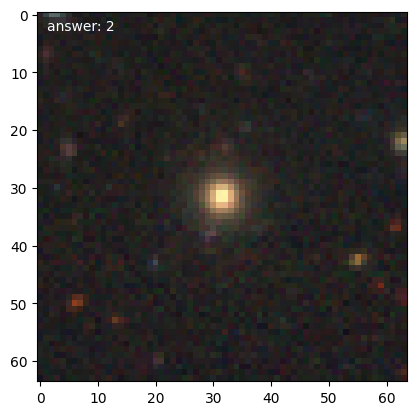

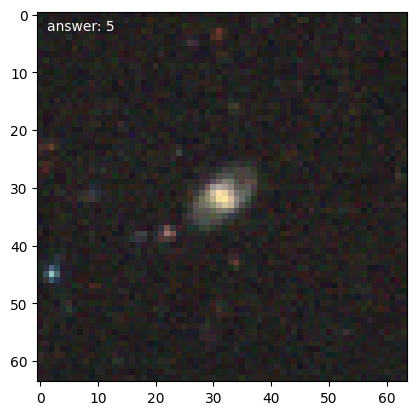

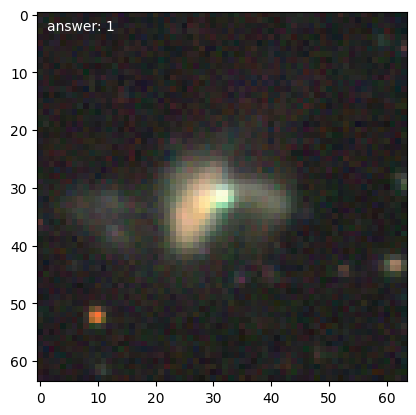

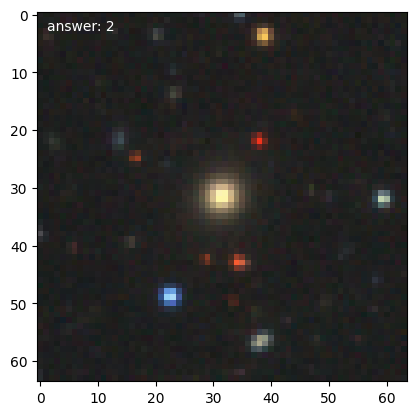

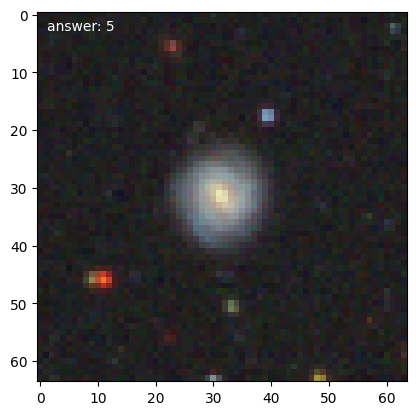

In [15]:
for n, g in enumerate(d.training_images()):
    g.plot()
    if n == 4:
        break

```{note}
Each time we access the generator it randomizes the galaxies in the training set.
```

## Implementing our neural network

We'll use just a single hidden layer.  If we use more hidden layers, then there are so many parameters that we will need to do a lot of training (epochs).

```{tip}
Our `DataManager` will tell us the size of the input layer, the number of batches, the batch size, etc.
```

In [17]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation

In [18]:
model = Sequential()
model.add(Input(shape=(d.input_shape,)))
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation="softmax"))

We'll use a different optimizer now, the `Adam` optimizer.  This is supposed to be one of the best that Keras provides.

In [19]:
from keras.optimizers import Adam

rms = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=rms, metrics=['accuracy'])

The keras `fit()` method can work with a generator directly, so we just pass in the generator.

In [ ]:
model.fit(d.batched_training_generator(),
          batch_size=d.batch_size,
          steps_per_epoch=d.n_batches,
          epochs=100)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 348ms/step - accuracy: 0.1451 - loss: 4.2680
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 355ms/step - accuracy: 0.2334 - loss: 2.0499
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 365ms/step - accuracy: 0.2580 - loss: 1.9662
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 356ms/step - accuracy: 0.2813 - loss: 1.9058
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.2942 - loss: 1.8797
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 353ms/step - accuracy: 0.3008 - loss: 1.8417
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 362ms/step - accuracy: 0.3187 - loss: 1.8013
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 365ms/step - accuracy: 0.3201 - loss: 1.8015
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 360ms/step - accuracy: 0.3323 - loss: 1.7789
Epoch 10/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 359ms/step - accuracy: 0.3284 - loss: 1.7792
Epoch 11/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 358ms/step - accuracy: 0.3234 - loss: 1.7869
Epoch 12